# Module 4. N-grams, traditional word vectors, and neural embeddings

In [53]:
import os
import re
import string

import numpy as np
import pandas as pd
import gensim as gs

import matplotlib.pyplot as plt
import seaborn as sns

from langdetect import detect

from ipywidgets import IntProgress
from IPython.display import display

%matplotlib inline

sns.set()

# Load the data

In [2]:
def read_file(path):
    with open(path) as f:
        return f.read()

def parse_content(topic, txt):
    obj = {"id": [], "content": [],}
    next_request = re.search(r"\d{7}\n", txt)
    while next_request:
        start = next_request.start()
        id = txt[:7]
        txt = txt[7:]
        
        next_request = re.search(r"\d{7}\n", txt)
        if not next_request:
            break
            
        start = next_request.start()
            
        request_content = txt[1:start]
        
        obj["id"].append(id)
        obj["content"].append(request_content)
        
        txt = txt[start:]
        
    obj["topic"] = [topic] * len(obj["id"])
    return obj
    
def read_requests(folder):
    requests = {"id": [], "content": [], "topic": []}
    filenames = os.listdir(folder)
    
    progress_bar = IntProgress(min=0, max=len(filenames), description='Reading file:', bar_style='info')
    display(progress_bar)
    
    for filename in filenames:
        path = os.path.join(folder, filename)
        
        file_content = read_file(path)
        
        filename_without_ext, _ = os.path.splitext(filename)
        parsed_content = parse_content(filename_without_ext, file_content)
            
        requests["id"] += parsed_content["id"]
        requests["content"] += parsed_content["content"]
        requests["topic"] += parsed_content["topic"]
            
        progress_bar.value += 1
    
    return pd.DataFrame.from_dict(requests)

In [3]:
df = read_requests('./1551')

IntProgress(value=0, bar_style='info', description='Reading file:', max=188)

In [4]:
df.head()

,id,content,topic
0,3096223,"Хочу Вас спитати, маю я право на субсидію чи н...",Розрахунки--нарахування-та-перерахунок-субсидій
1,3401866,"Добрый день, подскажите как оформить субсидию ...",Розрахунки--нарахування-та-перерахунок-субсидій
2,3382672,При подаче декларации и заявления на субсидию ...,Розрахунки--нарахування-та-перерахунок-субсидій
3,3354708,Питання про надання субсидій. Чому ходять чутк...,Розрахунки--нарахування-та-перерахунок-субсидій
4,3350015,Цього року я подала поштою необхідні документи...,Розрахунки--нарахування-та-перерахунок-субсидій


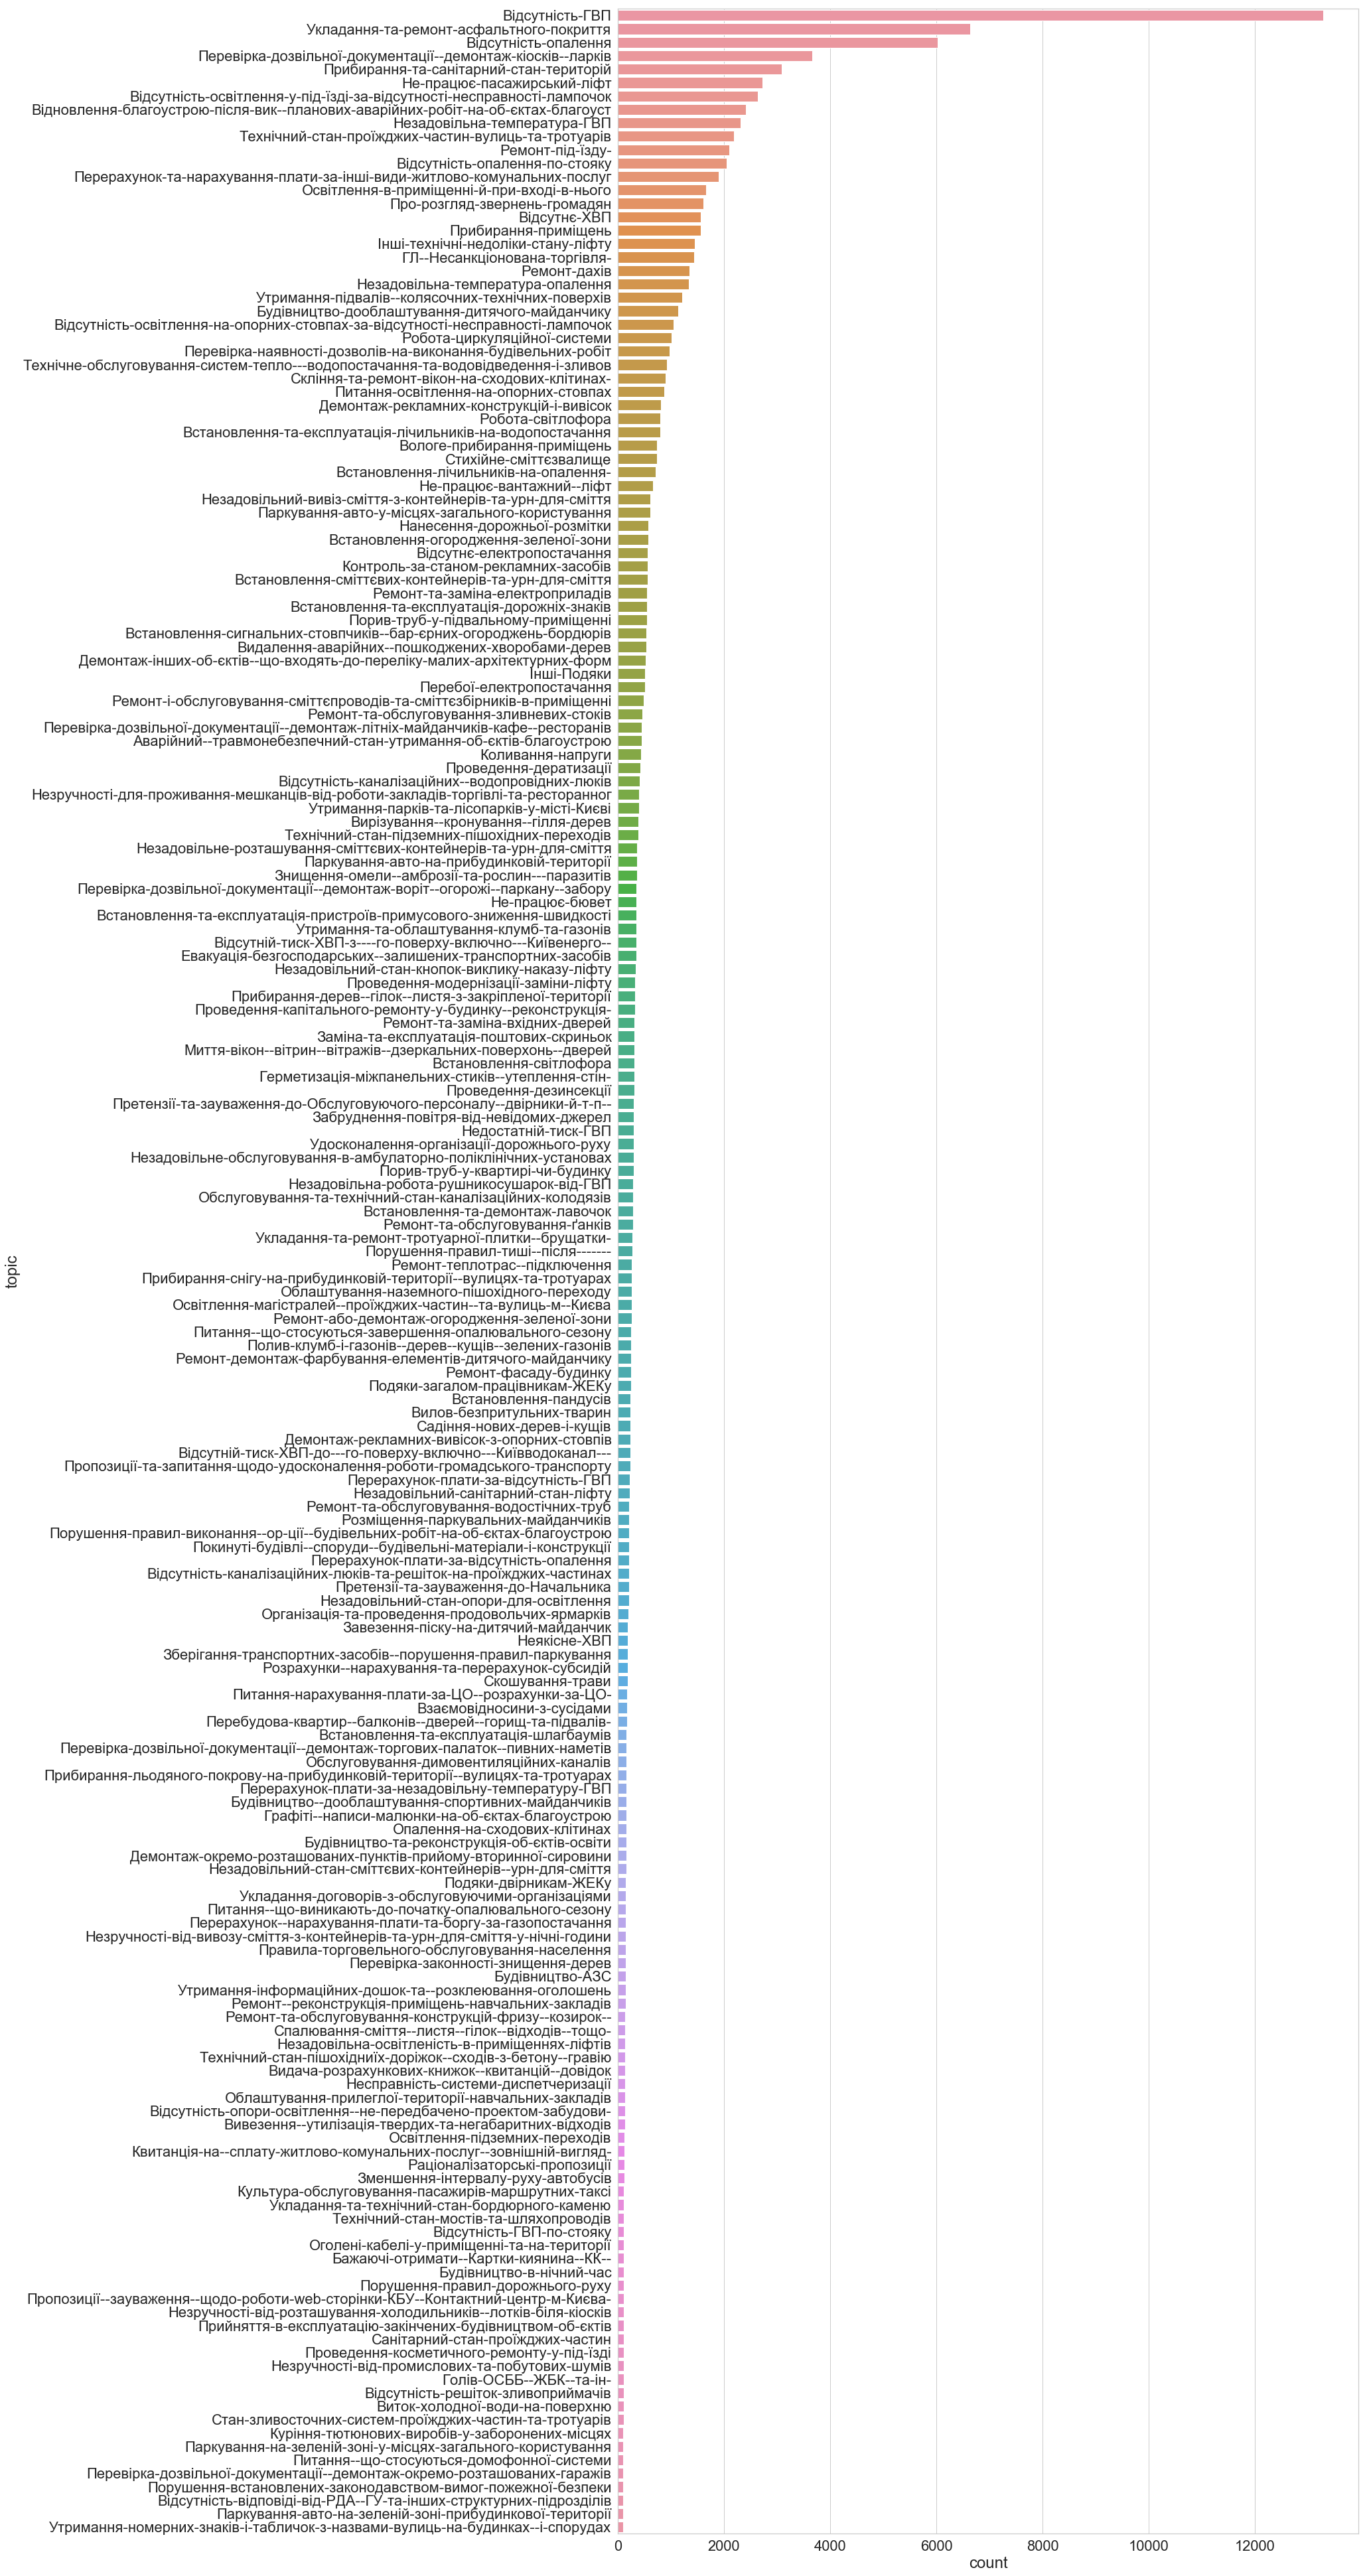

In [60]:
def count_plot(df):
    plt.figure(figsize=(20, 70))
    sns.set(font_scale = 2)
    sns.set_style('whitegrid')
    return sns.countplot(y='topic', data=df, order = df['topic'].value_counts().index)

ax = count_plot(df)

# Preprocessing

[Article about preprocessing](https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908)

Stop words are taken from "Mining massive datasets" UCU [course project](https://github.com/andreyurkiv/mmds-word-embeddings/blob/master/data/stop_words)

For language detection [langdetect](https://pypi.org/project/langdetect/) package is used.

In [6]:
stop_words = read_file('./stop_words.txt')
stop_words = stop_words.split('\n')

In [18]:
df["content"] = df["content"].apply(lambda x: x.lower()) # to lower case
df["content"] = df["content"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) # remove punctuation
df["content"] = df["content"].apply(lambda x: re.sub(r"\d+", "", x)) # remove digits
df["content"] = df["content"].apply(lambda x: x.strip()) # remove multiple spaces
df["content"] = df["content"].apply(lambda x: re.sub(r"\n+", " ", x)) # remove blank lines
df["content"] = df["content"].apply(
    lambda x: ' '.join(
        list(filter(lambda x: x != '', [word if word not in stop_words else '' for word in x.split(' ')]))
    )
) # remove stop words

In [19]:
df.iloc[0]["content"]

'хочу спитати маю право субсидію квартирі прописані дочка батько помер мав інваліда війни групипільги вдова померлого оформила трикімнатна крартира місяць рахунки більші мою пенсіюдочка навчається доходів моєї пенсії повагою гончаренко олена віталіївна конт'

In [20]:
df.shape

(114882, 3)

In [58]:
def detect_lang(df):
    progress_bar = IntProgress(min=0, max=df.shape[0], description='Detecting:', bar_style='info')
    display(progress_bar)

    def check_lang(string):
        nonlocal progress_bar 
        progress_bar.value += 1
        try:
            return detect(string)
        except Exception as e:
            return 'ru'

    df["language"] = ''
    df["language"] = df["content"].apply(check_lang)

    print("langdetect applied")

    df["language"] = df["content"].apply(
        lambda x: 'ru' if 
            'ъ' in x or \
            'ё' in x or \
            'ы' in x or \
            'э' in x else 'uk'
    )
    
    print("specific chars checked")
    
    return df

In [59]:
# remove non ukrainian requests
df = detect_lang(df)

IntProgress(value=0, bar_style='info', description='Detecting:', max=114882)

langdetect applied
specific chars checked


In [67]:
df = df[df["language"] == "uk"]

In [69]:
df.shape
df.head()

,id,content,topic,language
0,3096223,хочу спитати маю право субсидію квартирі пропи...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
3,3354708,питання надання субсидій ходять чутки продажі ...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
4,3350015,подала поштою необхідні документи заяву деклар...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
7,3223482,відділі супсидій повинні автоматично перерахув...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
8,3075714,оформити звертатися оформлення субсидії працюю...,Розрахунки--нарахування-та-перерахунок-субсидій,uk


# KNN classifier

In [ ]:
df

# Improvements:

- Logistic Regression 
- SVM 
- Random Forest
- TF-IDF
- LDA

# NN, LSTM